In [106]:
import cv2 as cv
import numpy as np
import utilities
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.widgets as widg
from matplotlib.colors import NoNorm
import scipy as sp
import os
import configparser

# 0. Loading data and parameters

In [107]:
# Insert path + filename here:
path = "experiments/test/"
filename = "small_SrTiO3_1244.png"

In [108]:
inputfile = path + filename
path, fname, extension = utilities.get_filename_parts(inputfile)

if os.path.isfile(path+"parameters.ini"):
    conf = configparser.ConfigParser(allow_no_value=True)
    conf.read_file(open(path+"parameters.ini"))
    
    #[SIFT]
    cThr = conf.getfloat('SIFT', 'contrast_threshold', fallback=0.003)
    sigma = conf.getfloat('SIFT', 'sigma', fallback=4)
    nOctLayers = conf.getint('SIFT', 'nOctaveLayers', fallback=8)
    
    #[Keypoint filtering]
    size_Threshold = conf.getfloat('Keypoint filtering', 'size_Threshold', fallback=2)
    edge_Threshold = conf.getfloat('Keypoint filtering', 'edge_Threshold', fallback=1)
    
    #[Keypoint Clustering]
    clustering_span_kp = range(conf.getint('Keypoint Clustering', 'nClusters_lower_bound',
                                           fallback=2),
                              conf.getint('Keypoint Clustering', 'nClusters_upper_bound',
                                          fallback=12))
    cluster_choice = conf.getint('Keypoint Clustering', 'cluster_choice', fallback=1)
    
    #[Nearest Neighbours]
    k1 = conf.getint('Nearest Neighbours', 'number of NN', fallback=6)
    cluster_span_kNN = range(conf.getint('Nearest Neighbours', 'nClusters_lower_bound',
                                         fallback=k1),
                              conf.getint('Nearest Neighbours', 'nClusters_upper_bound',
                                          fallback=4*k1))
    clustersize_Threshold = conf.getfloat('Nearest Neighbours', 'clustersize_Threshold',
                                          fallback=0.3)
    
    #[Sublattice Lookup]
    clustering_span_SUBL = range(conf.getint('Sublattice lookup', 'nClusters_lower_bound',
                                             fallback=2),
                              conf.getint('Sublattice lookup', 'nClusters_upper_bound',
                                          fallback=6))
    
    #[Deviation plot]
    k2 = conf.getint('Deviation plot', 'number_of_NN', fallback=10)
    rtol_rel = conf.getfloat('Deviation plot', 'relative_r-Tolerance', fallback=4)
    arrow_width = conf.getfloat('Deviation plot', 'arrow_width', fallback=0.003)

    
else:       #DO NOT MODIFY! Default values here, modify the parameters.ini file if needed.
    #[SIFT]
    cThr = 0.003
    sigma = 4
    nOctLayers = 8
    
    #[Keypoint filtering]
    size_Threshold = 2
    edge_Threshold = 1

    #[Keypoint Clustering]
    clustering_span_kp = range(2, 12)
    cluster_choice = 1
    
    #[Nearest Neighbours]
    k1 = 6
    cluster_span_kNN = range(k1, 4*k1)
    clustersize_Threshold = 0.3

    #[Sublattice lookup]
    clustering_span_SUBL = range(2, 6)

    #[Deviation plot]
    k2 = 10
    rtol_rel = 4
    arrow_width = 0.003


# 1. Getting keypoints via Scale-Invariant-Feature-Tranform(SIFT)

The goal here is to take the input image and run SIFT over it extracting keypoints and descriptors.
**SIFT** is feature extractor and descriptor algorithm. It utilizes several *Laplacian of Gaussian* (LoG) filters at multiple scales to detect blobs (points of interest) in the image. After detecting those features a descriptor is generated for all of them. SIFT descriptors encode the local intensity gradient environment surrounding a keypoint. Gradients within a certain pixel around the keypoint are weighted and combined into a single 128 dimensional vector. The weights are chosen in such a way depending on the scale at which the keypoint was found, making the descriptors themselves invariant under scaling. Rotation invariance is achieved by constructing a local coordinate frame on top of the keypoint, taking into account the directions of the gradients. 

Nice minimal intros at: <br>
Good theory: https://courses.cs.washington.edu/courses/cse576/11sp/notes/SIFT_white2011.pdf <br>
Documentation: https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html <br>

Secondaty sources: <br>
Basic intro: https://www.geeksforgeeks.org/sift-interest-point-detector-using-python-opencv/ <br>
Good theory and examples, alt.: https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/ <br>
YouTube videos: https://www.youtube.com/watch?v=KgsHoJYJ4S8&list=PL2zRqk16wsdqXEMpHrc4Qnb5rA1Cylrhx&index=12 <br>
Descriptors comparison: https://www.techgeekbuzz.com/sift-feature-extraction-using-opencv-in-python/ <br>

Image to be inspected:


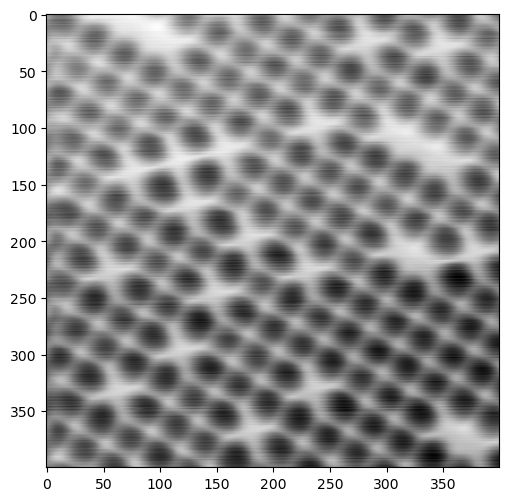

In [109]:
img = cv.imread(inputfile)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
#gray = cv.medianBlur(gray, 5)

print("Image to be inspected:")
plt.figure(figsize=(6,6), dpi=100, facecolor="w", edgecolor="k")
gray_cmap = utilities.get_correctGreyCmap("greyscale")
plt.imshow(gray, cmap=gray_cmap, vmin=0, vmax=255)
plt.show()

The next cell is where SIFT is applied for the first and last time, meaning that no new keypoints will be extracted other than these. [SIFT] parameters in the *parameters.ini* file must be set such that the majority of the circles surround the features of interest/blobs(i.e. atoms). If blobs bigger or smaller than average are detected, usually this won't affect the overall prediction since only the most populated clusters will be taken into account. <br>

**[SIFT] parameters suggestions**. <br>
See the [documentation](https://github.com/MarcoCrr/Lattice-symmetry-recognition/blob/master/README.md) for a brief description of the parameters. <br>
- *cThr*. Stay around the default value of 0.003, which is low enough to capture weak features that will be discarded later on;
- *sigma*. Very important parameter; on the practical side lowering the sigma will detect smaller keypoints, which can be useful for some images. The default value of 4 is an intermediate setting; this is the first parameter to be modified among the three as it greatly affects the prediction;
- *nOctLayers*. Increasing its value allows to detect keypoints more accurately, but missing some important features usually won't affect the lattice prediction. The default value of 8 is an intermediate setting.

Threshold: 0.003 
Sigma: 4 
Number of octave layers: 8


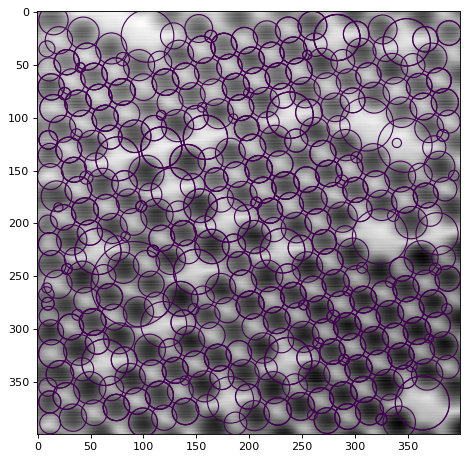

In [110]:
#SIFT application:
print('Threshold:', cThr, '\nSigma:', sigma, '\nNumber of octave layers:', nOctLayers)

sift = cv.xfeatures2d.SIFT_create(contrastThreshold=cThr, sigma=sigma,
                                  nOctaveLayers=nOctLayers)
kp = sift.detect(gray, None)
utilities.plot_clusters(np.array(gray), kp, labels=np.zeros(np.size(kp)), fill=False,
                        colormap="viridis")

## 1.5 Preliminary cleaning

The sizes of the atomic blobs that we are interested in may all be quite similar. SIFT detects blobs of different sizes which can lead to the identification of very large or small unphysical keypoints that don't describe the atoms/defects anymore. <br>
To solve this issue we focus on a smaller range of sizes around the median of all detected keypoints. This is done *before* any clustering process. In the next two code cells the [Keypoint_filtering] parameters are used. <br>
**Filtering parameters suggestions**: <br>
- *size_Threshold*: usually between 1.5 and 2.5, its tuning depends on the image and the SIFT predictions. Leaving the default value of 2 is usually sufficient.
- *edge_Threshold*: leaving the default value of 1 is recommended, the final prediction won't be affected much by this parameter.

In [111]:
sizes = [kp[i].size for i in range(np.size(kp))]
size_med = np.median(sizes)
kp = list(kp) 
wrongsize_index = [i for i in range(np.size(kp))\
                   if kp[i].size>size_Threshold*size_med or kp[i].size<size_med/size_Threshold
                  ]
wrongsize_index.reverse()
for i in wrongsize_index:
    del kp[i]
    

Keypoints that are right on the edge of the image are sometimes not be correctly positioned. They are also removed from further calculations.

In [112]:
border = edge_Threshold*size_med
edgeKP_indices = []
for i in range(np.size(kp)):
    if (kp[i].pt[0]<border or kp[i].pt[0]>np.shape(gray)[1]-border or\
        kp[i].pt[1]<border or kp[i].pt[1]>np.shape(gray)[0]-border):
        edgeKP_indices.append(i)
edgeKP_indices.reverse()
for i in edgeKP_indices:
    del kp[i]

If two 2 keypoints have the same xy coordinates, the first one is deleted.

In [113]:
kp, des_with_rot_inv = sift.compute(gray, kp) #~Atomtype Identification better result when
                                              #doing descriptors before removing same-x kp.
kp = list(kp)
x = np.array([kp[i].pt for i in range(np.size(kp))])
x, uniqueXindices = np.unique(x, return_index=True, axis=0)

for i in range(np.size(kp)-1, -1, -1):
    if i not in uniqueXindices:
        del kp[i]

After cleaning:


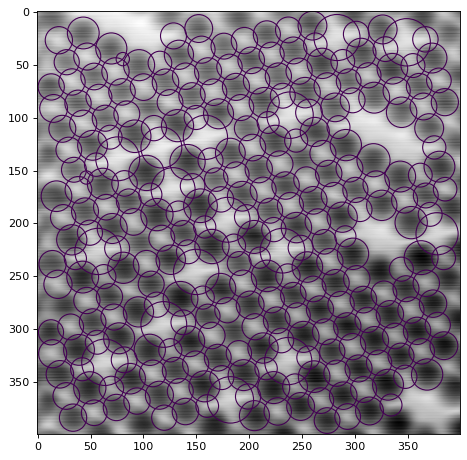

Distribution of the keypoints sizes:


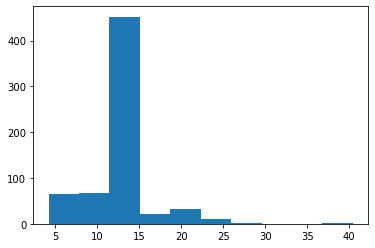

In [114]:
print('After cleaning:')
utilities.plot_clusters(np.array(gray), kp, labels=np.zeros(np.size(kp)), fill=False,
                        colormap="viridis")
plt.show()

print('Distribution of the keypoints sizes:')
plt.figure()
plt.hist(sizes)
plt.show()

# 2. Clustering the keypoints based on their descriptors

Descriptors are then clustered using [AgglomerativeClustering](https://towardsdatascience.com/agglomerative-clustering-and-dendrograms-explained-29fc12b85f23). The problem here is that we don't know the precise number of clusters we need. One method to evaluate the quality of the clustering is to measure the [silhouette score](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c) of the clustering, which measures simulaneously the self-similarity of each cluster and the difference between pairs of clusters. A good clustering yields a silhouette score of 1, whereas the worst possible score is -1. <br>
We visualize the found clustering that maximizes this silhouette score by drawing colored circles on top of the image, where each color corresponds to a different cluster. The radius of each circle is chosen to be exactly the scale at which SIFT found the keypoint. <br>
**[Keypoint clustering] parameters suggestions:** <br>
- *clustering_span_kp*: keep the default value of (2, 12), it's unlikely that an image will contain more different types of features. It is probable that the predicted optimal number of clusters will be higher than the real human-recognized one: this is positive for the algorithm because it ensures that keypoints belonging to the same cluster *must* correspond with the same feature;
- *cluster_choice*: the default value of *1* selects the most populated cluster, but sometimes good predictions are made by choosing the second most populated one.

It is first needed to compute the descriptors. To break the rotational invariance and compare keypoints that might have different local coordinate directions, set all these angles/directions to 0:

In [115]:
for i in range(np.size(kp)):
    kp[i].angle = 0

kp, des = sift.compute(gray,kp)

In [116]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score


def find_best_clustering(
    descriptors, span,
    sklearn_clustering=AgglomerativeClustering, **kwargs):
    '''
    Finds the optimal number of clusters of the given descriptors
    with respect to the silhouette score.
    
    Parameters:
    -----------
    descriptors - array of size (n,d), for n features with d descriptors;
    span - a range of values where the optimal number of clusters should be.
    **kwargs - additional possible arguments for AgglomerativeClustering.
    
    Result:
    -------
    best_labels - for each descriptor returns a label specifying the described
                  features cluster.
    '''
    max_SC = 0 #max score
    labels = np.zeros(np.shape(descriptors)[0])
    for N in span:
        clustering = sklearn_clustering(n_clusters=N, **kwargs).fit(descriptors)
        labels = clustering.labels_
        sil_score = silhouette_score(descriptors, labels)
        if sil_score > max_SC:
            best_labels = labels #each keypoint has an integer specifying its cluster
            max_SC = sil_score
    print("Maximal silhouette score found with {} clusters:\nsil_score = {}"
          .format(max(set(best_labels))+1, max_SC))
    return best_labels


labels = find_best_clustering(des, span=clustering_span_kp,
                              sklearn_clustering=AgglomerativeClustering)

Maximal silhouette score found with 11 clusters:
sil_score = 0.2590838372707367


Below are all keypoints plotted, colored according to their label. The size of the circle is the exact scale at which the keypoint was found, and thus also shows which parts of the image are used for the descriptor.

Clusters visualization:


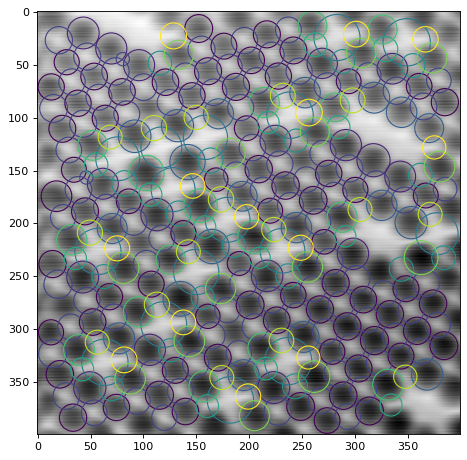

In [117]:
print('Clusters visualization:')
utilities.plot_clusters(np.array(gray), kp, labels, fill=False, colormap="viridis")
plt.savefig(path+"clustered_kps.svg")
plt.show()

This first clustering process is needed to detect the most populated cluster, to be used as a reference to detect the other sublattices. There are usually some equivalent lattice sites which are differently labelled. If this happened there is no need to re-tune the previous parameters.

# 3.Extracting Lattice Vectors

Lattice vectors are defined to connect equivalent lattice sites. There are several challenges here that we have to overcome. 
 - There might be multiple sublattices of keypoints detected in the image which could mess up the calculation;
 - we want our method to work on different types of lattices, not only the simple ones;
 - the atoms in the image will never lie on their perfect lattice positions. There's always some amount of distortion;
 - there are some ambiguities in choosing the lattice vectors, to make this method working we have to make sure to always eliminate ambiguities;
 - the clustering will not always be perfect and we don't want the method to break down because of a few misclassified atoms.

To extract the lattice vectors, we first **eliminate all sublattices but one**, that will be the reference cluster for the analysis that follows. The user can choose the reference cluster by setting the parameter *cluster_choice* (as mentioned above), but it is recommended to stick on the first or second most populated one.

Sorted clusters' population: [85, 69, 19, 17, 17, 16, 16, 16, 14, 14, 13]
Pop. of the chosen cluster: 85
Most populated cluster:


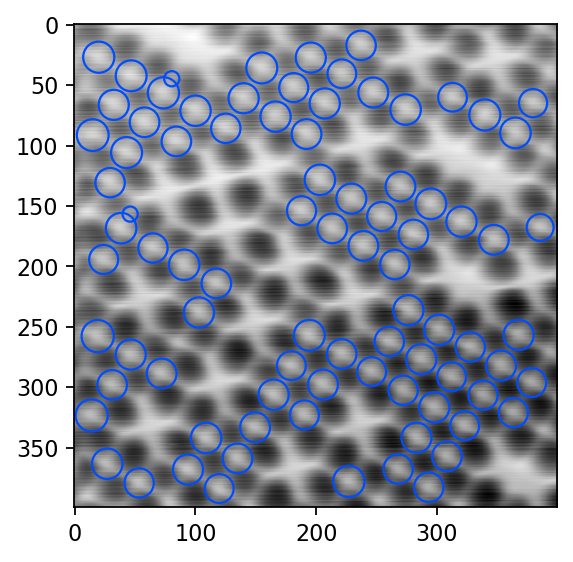

In [135]:
#cluster label with maximum number of keypoints:
bins = np.bincount(labels)
bins = list(bins)
bins_old = bins
ref_cluster = cluster_choice -1
bins = sorted(bins, reverse=True)
print('Sorted clusters\' population:', bins)

lab_max = bins[ref_cluster]
print('Pop. of the chosen cluster:', lab_max)
for i in range(len(bins)):
    if bins_old[i] == lab_max:
        l_max = i
        break
#l_max = np.argmax([np.size(labels[labels==i]) for i in set(labels)])

fig=plt.figure(figsize=(4,4), dpi=160, facecolor='w', edgecolor='k')
utilities.plot_one_cluster(np.array(gray), kp, labels, l_max, fill=False)
print('Most populated cluster:')
plt.savefig(path+"single_cluster.svg")
plt.show()

Sometimes there will already be a problem here. Some keypoints with different size can happen to have quite similar descriptors to the other ones. Of course in this case we easily filter out the "bad" keypoints by setting a threshold on the size. However, mistakes like these are made by the clustering algorithm; we can't rely on it and want to build a method that can deal with these sorts of issues.<br>
If we focus on the regular circles, the primitive lattice vectors correspond to their first nearest neighbours. Let's calculate the first few nearest neighbours for all of these keypoints and view the resulting plot. <br>
**[Nearest neighbours] parameters suggestions:** <br>
- *k1*: usually the default value of 6 is enough, as the silhouette score will define the optimal number of NN in the end;
- *cluster_span_kNN*: usually keep the default interval from k1 to 4\*k1 . 
- *clustersize_Threshold*: the most 'rare' detected nearest neighbours are discarded, since they are probably misclassified keypoints. Usually keep the default value of 0.3, meaning that only the clusters with *population $\geq$ max_pop_cluster\*clustersize_Threshold* will be considered.

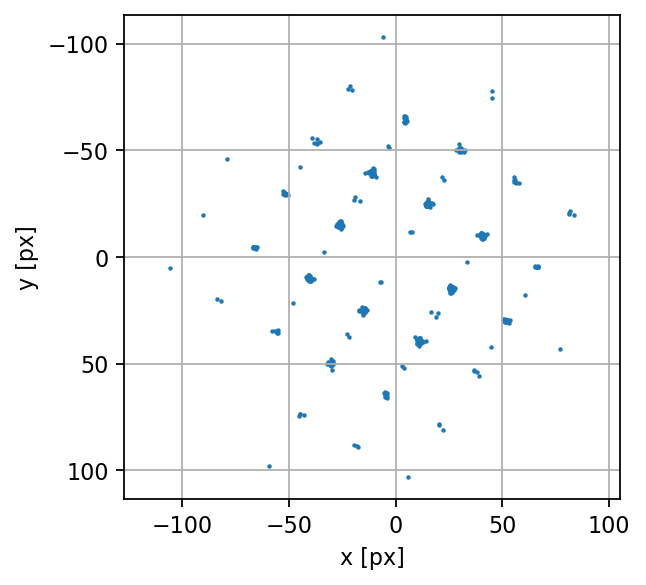

In [119]:
x = np.array([kp[i].pt for i in range(np.size(kp))]) #kp coordinates
x_ofMaxCluster = np.unique(x[labels==l_max,:], axis=0)
x = np.unique(x, axis=0)
kNN = utilities.kNearestNeighbours(x_ofMaxCluster, k1)

plt.figure(figsize=(4,4), dpi=160)
plt.axis("equal")
plt.gca().invert_yaxis()
plt.grid()
plt.scatter(kNN[:,0], kNN[:,1], s=1)
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.savefig(path+"NNV_original.svg")
plt.show()

Above you can see the distribution of the detected nearest neighbors positions for each keypoint of the most populated cluster. We also have some noise that comes from erroneously labeled keypoints.<br>
To extract the primitive lattice vectors we want to choose two linearly independent peaks with the least combined arc length. However, there will be a nearest neighbour at both +**a** and -**a** for any lattice vector **a**. To eliminate this ambiguity, we mirror all nearest Neighbours that lie in negative x direction through the origin.

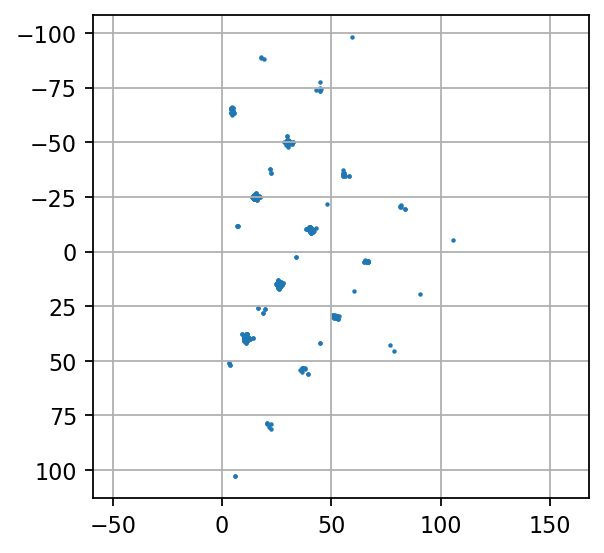

In [120]:
kNN_posX = np.array([-kNN[i,:] if kNN[i,0]<0 else kNN[i,:] for i in range(np.shape(kNN)[0])])

plt.figure(figsize=(4,4), dpi=160)
plt.axis("equal")
plt.gca().invert_yaxis()
plt.grid()
plt.scatter(kNN_posX[:,0], kNN_posX[:,1], s=1)
plt.show()

Now to get the peak positions we cluster the obtained unambiguous nearest Neighbours and calculate the average positions of each cluster. To get the right number of clusters we can reuse find_best_clustering() from before.
To eliminate the small noisy clusters that might be placed near to the origin we will only consider peaks which have sufficiently many points around them.

In [121]:
print("Clustering NNV's of maximally represented feature class:")
kNN_labels = find_best_clustering(kNN_posX, span=cluster_span_kNN)

#The potential lattice vectors are the average vectors of each cluster:
average_peaks = np.array(
    [np.average(kNN_posX[kNN_labels==l,:], axis=0) for l in set(kNN_labels)])

Clustering NNV's of maximally represented feature class:
Maximal silhouette score found with 23 clusters:
sil_score = 0.9016814594043665


Further reduce these vectors based on how big the found clusters are to prevent noise-derived small clusters near the origin to mess with the result.

Primitive vectors coordinates:
a = ( 15.07 +/- 0.66,-25.04 +/- 0.64)
b = ( 25.95 +/- 0.65, 15.01 +/- 0.79)


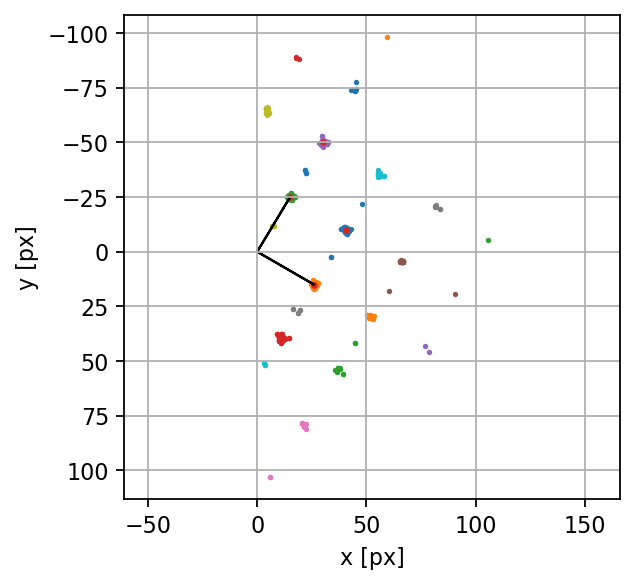

In [122]:
clustersizes = np.array([len(kNN_labels[kNN_labels==i]) for i in range(max(kNN_labels)+1)])
max_clustersize = np.max(clustersizes)
average_peaks = average_peaks[clustersizes>=max_clustersize*clustersize_Threshold,:]
labels_AP=np.arange(
            max(set(kNN_labels))+1)[clustersizes>=max_clustersize*clustersize_Threshold]

#find primitive lattice vectors
sorted_ind = np.argsort(np.linalg.norm(average_peaks, axis=1))
average_peaks = np.take_along_axis(
                                   average_peaks,
                                   sorted_ind.repeat(2).reshape(np.shape(average_peaks)),
                                   axis=0)
labels_AP = np.take_along_axis(labels_AP, sorted_ind, axis=0)

found = False
for i in range(np.shape(average_peaks)[0]):
    if found == True: break  
    for j in range(i+1, np.shape(average_peaks)[0]):
        if np.abs(np.cos(utilities.angle_between(average_peaks[i,:],
                                                 average_peaks[j,:])))<0.95:
            a = average_peaks[i,:]
            b = average_peaks[j,:]
            cluster_a = labels_AP[i]
            cluster_b = labels_AP[j]
            found = True
            break
if found==False:
    print("Something went wrong ... a,b not found")

    
std_a = np.std(kNN_posX[kNN_labels==cluster_a,:], axis=0)
std_b = np.std(kNN_posX[kNN_labels==cluster_b,:], axis=0)

print("Primitive vectors coordinates:")
print("a = ({:6.2f} +/-{:5.2f},{:6.2f} +/-{:5.2f})\n\
b = ({:6.2f} +/-{:5.2f},{:6.2f} +/-{:5.2f})".\
      format(a[0], std_a[0], a[1], std_a[1], b[0], std_b[0], b[1], std_b[1]))


plt.figure(figsize=(4,4), dpi=160)
utilities.plot_clustered_NNVs(kNN_posX, kNN_labels, average_peaks, a, b)
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.grid()
plt.savefig(path+"NNV_1cluster.svg")
plt.show()


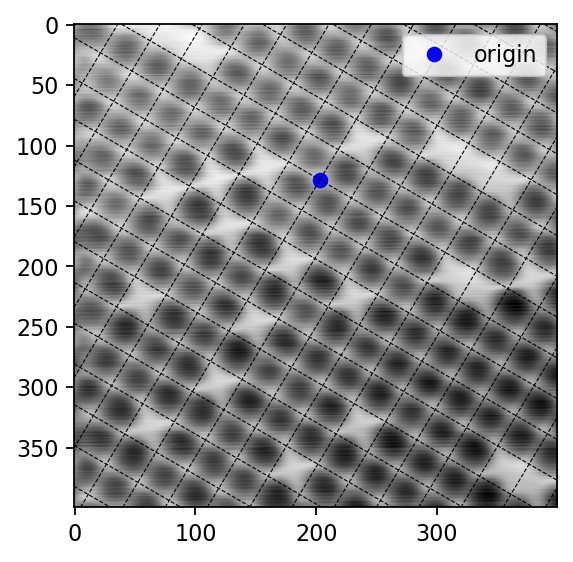

In [123]:
#Plot a grid overlay according to the found lattice
plt.figure(figsize=(4,4), dpi=160)
plt.imshow(gray, cmap=gray_cmap, norm=NoNorm())
utilities.plot_grid(x_ofMaxCluster[np.shape(x_ofMaxCluster)[0]//2,:], a, b, linewidth=0.5)
plt.savefig(path+"gridoverlay.svg")
plt.show()

# 4. Finding Sublattice Positions

Having found the primitive lattice vectors, we can go back and look at all our original keypoints again. In crystallography, a bravais lattice is always made up of a lattice (i.e. the primitive lattice vectors) and a basis (i.e. sublattice positions). For one chosen lattice, we want to know where the rest of the keypoints are positioned within this lattice.<br>
This is now fairly straightforward to do. For any given keypoint we can look at its nearest lattice point and then transform it into that lattice points unit cell. The sublattice positions are obtained by clustering the points and calculating the center of mass of each cluster.

In [124]:
def sublattice_lookup(x, x_lat, a, b, SUBLplot, possibleNoSubl):
    '''
    For each point x[i], search for nearest point x_lat[i]
    and fold x[i] into unit cell of x_lat[i] with respect to lattice vectors a and b 
    then cluster x's based on where they were folded to.
    
    Parameters:
    ----------    
    Input:
    x - array(N,2). Points to be grouped into sublattice positions.
    x_lat - array(M,2). Points that are known to lie on the lattice.
    a,b - arrays. Lattice vectors coordinates.
    SUBLplot - boolean to decide wether or not to plot the sublattice positions.
    possibleNoSubl - interval containing the optimal number of sublattice positions.
    
    Output:
    subl - center of masses (COM) of clusters in unit cell.
    subl_labels - for each input x a label specifying the cluster it belongs to.
    '''

    #To speed up the following nearest neighbour look ups
    #I arange the lattice points in a K-d-Tree
    tree = sp.spatial.KDTree(x_lat,leafsize=6)

    #lattice position of remaining x's when folded in the chosen unit cell:
    x_fd = np.zeros(np.shape(x))
    for i in range(np.shape(x)[0]):
        #look up the nearest lattice point which isn't itself:
        d,j = tree.query(x[i,:], k=6) #search the k-NN: d=distances, j=indices (arrays)
        j = j[d>0.001] #shrinks the array with only meaningful elements
        x_fd[i,:] = np.linalg.solve(np.array([a,b]).T, x[i,:]-x_lat[j[0],:])%1

    print("Calculating distance matrix of folded back points ...")
    d_matrix = sp.spatial.distance.cdist(x_fd, x_fd, lambda u,v: dist_per(u,v,a,b))
    print("done")

    print("Clustering keypoints based on their position in the lattice that has been found\
    (i.e. sublattice found):")
    subl_labels = find_best_clustering(d_matrix, span=possibleNoSubl, affinity="precomputed",
                                       linkage="average")
    subl = np.array([COM(x_fd[subl_labels == i,:]) for i in set(subl_labels)])

    if SUBLplot:
        #transform all coordinates back to the original dimensions
        x_fd2 = np.array([np.matmul(np.array([a,b]).T, x_fd[i,:]) 
                          for i in range(np.shape(x_fd)[0])])
        subl2 = np.array([np.matmul(np.array([a,b]).T, subl[i,:])
                          for i in set(subl_labels)])
        plt.figure(figsize=(8,8), dpi=80)
        plt.axis("equal")
        plt.gca().invert_yaxis()
        plt.title("Sublattice positions")
        plt.xlabel("x[px]")
        plt.ylabel("y[px]")
        for i in set(subl_labels):
            plt.scatter(x_fd2[subl_labels==i, 0], x_fd2[subl_labels==i, 1], label=i)
        plt.legend()
        
        plt.scatter(subl2[:,0], subl2[:,1])
        plt.arrow(0, 0, a[0], a[1])
        plt.arrow(0, 0, b[0], b[1])
        plt.savefig(path+"sublattice_positions.svg")
        plt.show()
       
    return subl, subl_labels

def dist_per(u, v, a, b):
    '''
    Calculates distances in a 1x1 unit cell with periodic boundary conditions.
    
    Parameters:
    ----------    
    Input:
    u, v - arrays. Two points which distance is to be calculated.
    a, b - arrays. Coordinates of the lattice vectors.
    
    Output:
    d - float. Distance.      
    '''
    deltax = np.abs(u - v)
    d = np.sqrt(\
            np.sum(\
             np.matmul(np.array([a,b]).T,
                    np.amin(\
                        np.array([deltax, 1-deltax])\
                        ,axis=0))**2\
            )\
        )
    return d

def COM(x):
    '''
    Calculates the average position of each cluster (Center Of Mass)
    following COM calculation by Linge Bai and David Breen:
    "Calculating Center of Mass in an Unbounded 2D environment".
    
    Parameters:
    ----------    
    Input:
    x - array. Coordinates of keypoints belonging to the same cluster.
    
    Output:
    COM - array. Cordinates of the center of mass.
    '''
    
    N,k = np.shape(x)
    COM = np.zeros(2)
    ri = 1/(2*np.pi)
    #first component:
    theta_i = x[:,0]*2*np.pi
    x1 = np.zeros((N,3))
    x1[:,0] = ri*np.cos(theta_i)
    x1[:,1] = x[:,1]
    x1[:,2] = ri*np.sin(theta_i)
    X_bar = np.average(x1, axis=0)
    if np.abs(X_bar[0]) >= 0.001 and np.abs(X_bar[2])>=0.001:
        theta = np.arctan2(-X_bar[2],-X_bar[0])+np.pi
    else:
        theta = 0
    COM[0] = ri*theta
    #second component:
    theta_i = x[:,1]/ri
    x1[:,0] = x[:,0]
    x1[:,1] = ri*np.cos(theta_i)
    x1[:,2] = ri*np.sin(theta_i)
    X_bar = np.average(x1,axis=0)
    if np.abs(X_bar[0]) >= 0.001 and np.abs(X_bar[2])>=0.001:
        theta = np.arctan2(-X_bar[2], -X_bar[1])+np.pi
    else:
        theta = 0
    COM[1] = ri*theta
    return COM

**[Sublattice lookout] parameter**:
- *clustering_span_SUBL*: interval containing the correct size of the basis. The default interval from 2 to 6 is wide enough and it will hardly needed to be changed. The optimal number of atoms in the basis will be found via silhouette score calculation anyway.

Calculating distance matrix of folded back points ...
done
Clustering keypoints based on their position in the lattice that has been found    (i.e. sublattice found):
Maximal silhouette score found with 2 clusters:
sil_score = 0.8843682288619835


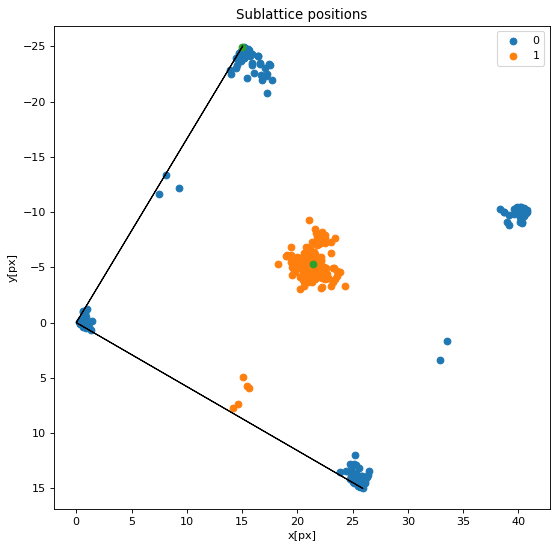

sublattice positions (in units of the lattice vectors):
[[0.99463518 0.        ]
 [0.52444955 0.51927298]]


In [125]:
subl, subl_labels = sublattice_lookup(x, x_ofMaxCluster, a, b, SUBLplot=True,
                                      possibleNoSubl=clustering_span_SUBL)
print("sublattice positions (in units of the lattice vectors):\n{}".format(subl))

For the determination of symmetric operations it is important to know what elements of sublattice represent the same chemical element (or vacancy thereof). To determine this we  repeat a clustering of the initial keypoints but with rotation invariance included.
Since we know what keypoints represent the sublattice elements we optimize for a rotation invariant clustering in which the largest portion of a sublattice element (i.e. the ones just found) agrees with a rotation invariant cluster. To do this we repeat clustering inside clusters.

Maximal silhouette score found with 2 clusters:
sil_score = 0.13348037004470825
there are  100.0  percent atomtype  0  in sublattice  0  other way round:  90.06155241271793
there are  0.0  percent atomtype  1  in sublattice  0  other way round:  0.0
there are  10.596026490066226  percent atomtype  0  in sublattice  1  other way round:  9.937826473127496
there are  89.40397350993378  percent atomtype  1  in sublattice  1  other way round:  99.99925926474619
Optimizaion scores:  [0.14985044369516237]


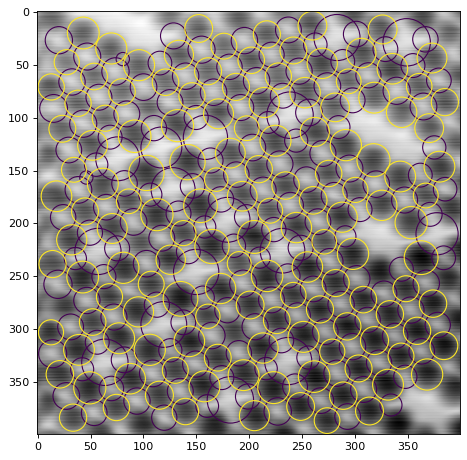

Maximal silhouette score found with 2 clusters:
sil_score = 0.17931270599365234
there are  24.137931034482758  percent atomtype  0  in sublattice  0  other way round:  99.99714293877318
there are  75.86206896551724  percent atomtype  1  in sublattice  0  other way round:  87.30089443734573
there are  0.0  percent atomtype  0  in sublattice  1  other way round:  0.0
there are  100.0  percent atomtype  1  in sublattice  1  other way round:  12.69831191815938
Optimizaion scores:  [0.14985044369516237, 0.3413618943659195]


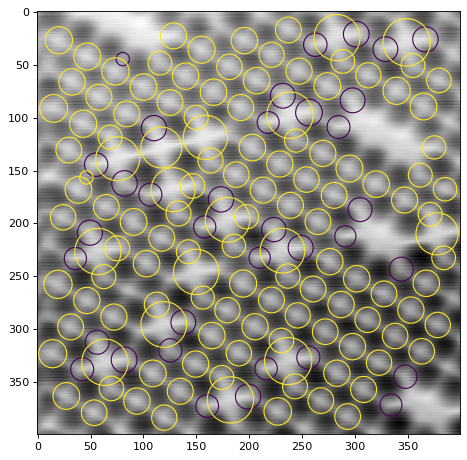

Maximal silhouette score found with 2 clusters:
sil_score = 0.20007632672786713
there are  nan  percent atomtype  0  in sublattice  0  other way round:  0.0
there are  nan  percent atomtype  1  in sublattice  0  other way round:  0.0
Optimizaion scores:  [0.14985044369516237, 0.3413618943659195, nan]


<ipython-input-126-1ba62b6b7dfb>:33: RuntimeWarning: invalid value encountered in true_divide
  fraction = np.divide(len(intersection), total_size)


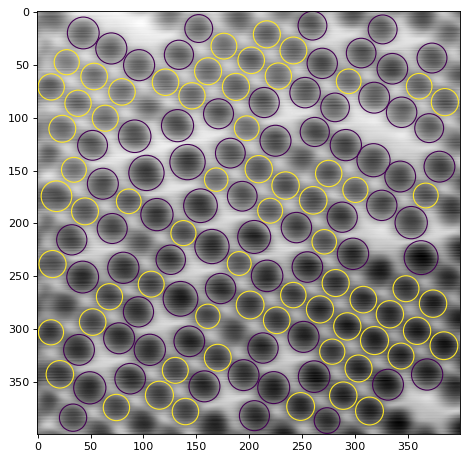

Atom types: [0, 1]


In [126]:
from scipy.spatial import distance

if len(subl) == 1:
    atomtypes = [0]
else:
    if len(subl) == 2:
        atomtype_span = [2]
    else:
        atomtype_span = range(2, len(subl))

    des_with_rot_inv_sub = np.take(des_with_rot_inv, uniqueXindices, axis=0)        
    labels_subl_no_rot = find_best_clustering(des_with_rot_inv, span=atomtype_span, 
                                              sklearn_clustering=KMeans, random_state=0)
    labels_subl_no_rot = np.take(labels_subl_no_rot, uniqueXindices) #opposite name?

    #temporaty names of pre-existing variables:
    sub_sub = subl_labels
    labels_sub_sub_no_rot = labels_subl_no_rot
    kp_sub = kp
    l = 0
    results = []
    #We optimize for a clustering where the sublattices fall closest into one cluster
    optimizationcheck = []
    while l < len(np.unique(labels_subl_no_rot)) + 1:
        results.append([])
        for k in range(len(np.unique(sub_sub))):
            sub_indices = np.where(sub_sub == k) #?
            total_size = len(sub_indices[0])
            results[l].append([])
            for i in range(len(np.unique(labels_subl_no_rot))):
                sub_no_rot_indices = np.where(labels_sub_sub_no_rot == i)
                intersection = np.intersect1d(sub_indices, sub_no_rot_indices)
                fraction = np.divide(len(intersection), total_size)
                fraction_atom = len(intersection) / (len(sub_no_rot_indices[0])+0.001)
                results[l][k].append(fraction)
                print("there are ", fraction * 100, " percent atomtype ", i,
                      " in sublattice ", k, " other way round: ", fraction_atom * 100)
        optimizationcheck.append(
            np.linalg.norm(
            distance.cdist(
                results[l], np.identity(len(np.unique(labels_subl_no_rot)))).min(axis=1)))  
        print("Optimizaion scores: ", optimizationcheck)
        
        utilities.plot_clusters(np.array(gray), kp_sub,
                                labels_sub_sub_no_rot, fill=False, colormap="viridis")
        plt.show()


        # Clustering is repeated inside every of the intitial clusters.
        if l < len(np.unique(labels_subl_no_rot)): 
            des_sub_sub_with_rot_inv = np.take(des_with_rot_inv_sub,
                                               np.where(labels_subl_no_rot==l), axis=0)[0]
            kp_sub = np.take(kp, np.where(labels_subl_no_rot==l))[0]
            sub_sub = np.take(subl_labels, np.where(labels_subl_no_rot==l))[0]
            labels_sub_sub_no_rot = find_best_clustering(
                                            des_sub_sub_with_rot_inv, span=atomtype_span,
                                            sklearn_clustering=KMeans, random_state=0)
        l += 1


    best_candidate = np.nanargmin(optimizationcheck)
    atomtypes = [np.argmax(fractions) for fractions in results[best_candidate]]

print("Atom types:", atomtypes)

# 5. Going beyond periodicity

Having extracted the necessary bits of a periodic lattice, we can now go beyond and also focus on deviations from this periodicity.<br>
**[Deviation plot] parameters suggestions:** <br>
- **k2**: number of nearest neighbors considered for each keypoint. *Default: 10*. You probably won't need to change this value;
- **rtol_rel**: all vectors that are within the relative_r-tolerance of the lattice vectors are drawn; *Default: 4*. Increasing this value will plot more arrows, and viceversa. It is the most important parameter among the three.
- **arrow_width**: the arrow_width can be specified (see [matplotlib.quiver() - width parameter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html)). *Default: 0.003*.


In [127]:
# OLD UNUSED FUNCTION!!!
def plot_lattice_deviations(x, a, b, subl_labels, k=15,
                            rtol_ini=2, sizes=10, arrow_width=0.003):
    '''
    As a final result plot the kNN-vectors from their respective keypoint,
    colored by how much they deviate from the found lattice vectors.
    '''
    kNN = utilities.kNearestNeighbours(x<k)
    #append the basis vectors to see which cluster they get mapped to
    kNN = np.append(kNN, [a,b]).reshape(np.shape(x)[0]*k+2, 2)
    kNN_right = np.array([kNN[i,:] if kNN[i,0]>=0 else -kNN[i,:] 
                          for i in range(np.shape(kNN)[0])])

    rtol = rtol_ini
    while True:
        kNN_red, kNN_labels = utilities.DensityClustering(kNN_right, rtol)

        plt.figure(figsize=(8,8), dpi=80)
        plt.axis("equal")
        for i in set(kNN_labels):
            plt.scatter(kNN_right[kNN_labels==i,0], kNN_right[kNN_labels==i,1], s=sizes)
        plt.scatter(kNN_red[:,0], kNN_red[:,1], label="reduced", s=sizes*4)
        plt.arrow(0, 0, a[0], a[1])
        plt.arrow(0, 0, b[0], b[1])
        plt.title("Nearest Neighbour vectors clustered and reduced, ", 
                  "rtol={}\nThis time for all keypoints".format(rtol))
        plt.savefig(path+"_KNN2.svg")
        plt.show()
        if utilities.yes_or_no("Change rtol?"):
            rtol = float(input("rtol = \n"))
        else:
            break
    diff = []
    for s in set(subl_labels):
        #I want to plot the NN-vectors for each sublattice
        #for that I need proper masks to seperate the sublattices out of x and kNN
        isinSubl = subl_labels == s
        kNNofSubl = isinSubl.repeat(k)
        kNNofSubl = np.append(kNNofSubl, [False,False])
        
        if kNN_labels[-2] != -1:
            plt.figure(figsize=(8,6), dpi=80)
            plt.imshow(gray, cmap=gray_cmap, norm=NoNorm())
            #plot all NN-vectors that belong to the first basis vector:
            is_a = kNN_labels == kNN_labels[-2]
            is_a[-2:] = [False]*2
            kp_inds1 = np.where(is_a & kNNofSubl)[0]//k
            kps1 = np.take(x, kp_inds1, axis=0)
            diff = np.append(diff, kNN_right[is_a & kNNofSubl,:]-a)
            diff = diff.reshape(np.size(diff)//2, 2)
            diff_magn = np.linalg.norm(kNN_right[is_a & kNNofSubl,:]-a, axis=1)
            #diff_magn = diff_magn/np.max(diff_magn)
            #diff_magn[diff_magn>8] = 8
            quiv1 = plt.quiver(kps1[:,0], kps1[:,1], kNN[is_a & kNNofSubl,0],
                               kNN[is_a & kNNofSubl,1], diff_magn,
                               cmap="plasma", scale_units="xy", angles="xy", scale=1,
                               width=arrow_width)

        #second basis vector:
        if kNN_labels[-1] != -1:
            is_b = kNN_labels == kNN_labels[-1]
            is_b[-2:] = [False]*2
            kp_inds1 = np.where(is_b & kNNofSubl)[0]//k
            kps1 = np.take(x, kp_inds1, axis=0)
            diff = np.append(diff, kNN_right[is_b & kNNofSubl,:]-b)
            diff = diff.reshape(np.size(diff)//2, 2)
            diff_magn = np.linalg.norm(kNN_right[is_b & kNNofSubl,:]-b, axis=1)
            #diff_magn = diff_magn/np.max(diff_magn)
            #diff_magn[diff_magn>8] = 8
            quiv1 = plt.quiver(kps1[:,0], kps1[:,1], kNN[is_b & kNNofSubl,0],
                               kNN[is_b & kNNofSubl,1], diff_magn,
                               cmap="plasma", scale_units="xy", angles="xy", scale=1,
                               width=arrow_width)
            cbar = plt.colorbar()
            cbar.ax.set_ylabel("deviation from average lattice vectors")
            plt.title("Deviation of NN-vectors from average lattice vector\nsublattice {}".format(s))
            plt.savefig(path+"deviations_{}.svg".format(s))
            plt.show()


    diff = np.array(diff)

    plt.figure(figsize=(8,8), dpi=80)
    plt.title("Deviations from primitive lattice vectors")
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.scatter(diff[:,0], diff[:,1], s=1)
    plt.savefig(path+"deviations.svg")
    plt.show()

In [128]:
import matplotlib.patches as patches
# This is the function that is actually used.
def plot_lattice_deviations2(x, a, b, subl_labels, k, rtol_rel,
                             arrow_width, colorsmin=None, colorsmax=None):
    '''
    As a final result plot the kNN-vectors from their respective keypoint,
    colored by how much they deviate from the found lattice vectors.
    In contrast to the previous function it just uses a threshold to decide
    which kNN's to plot.
    '''
    kNN = utilities.kNearestNeighbours(x, k)
    
    plt.figure(figsize=(8,8), dpi=80)
    plt.axis("equal")
    plt.gca().invert_yaxis()
    plt.title('NN to consider in the deviation plot')
    plt.scatter(kNN[:,0], kNN[:,1], s=1)
    ax = plt.gca()
    ax.add_patch(patches.Circle(a, radius=rtol_rel, fill=False, color=(0,0,0)))
    ax.add_patch(patches.Circle(b, radius=rtol_rel, fill=False, color=(0,0,0)))
    ax.add_patch(patches.Circle(-b, radius=rtol_rel, fill=False, color=(0,0,0)))
    ax.add_patch(patches.Circle(-a, radius=rtol_rel, fill=False, color=(0,0,0)))
    plt.arrow(0, 0, a[0], a[1])
    plt.arrow(0, 0, b[0], b[1])
    plt.arrow(0, 0, -a[0], -a[1])
    plt.arrow(0, 0, -b[0], -b[1])
    plt.show()
    
    diff = []
    #consistent coloring of arrows across quiver plots:
    quivernorm = matplotlib.colors.Normalize(vmin=colorsmin, vmax=colorsmax, clip=True)
    for s in set(subl_labels):
        #I want to plot the NN-vectors for each sublattice
        #for that I need proper masks to seperate the sublattices out of x and kNN
        isinSubl = subl_labels == s
        kNNofSubl = isinSubl.repeat(k)
        
        print('Sublattice {}:'.format(s))
        fig = plt.figure(figsize=(4,4), dpi=160)
        plt.imshow(gray, cmap=gray_cmap, norm=NoNorm())
        plt.axis("off")

        #plot all NN-vectors that belong to the first basis vector:
        is_a = (np.linalg.norm(kNN-a, axis=1) <= rtol_rel) 
        is_minus_a = (np.linalg.norm(kNN+a, axis=1) <= rtol_rel)
        to_draw = kNNofSubl & (is_a | is_minus_a)
        kp_inds1 = np.where(to_draw)[0]//k
        kps1 = np.take(x, kp_inds1, axis=0)
        
        diff = np.append(diff, kNN[is_a & kNNofSubl,:]-a)
        diff = np.append(diff, kNN[is_minus_a & kNNofSubl,:]+a)
        diff_magn = np.zeros(np.shape(kNN[to_draw,:])[0])
        
        for i in range(np.shape(kNN[to_draw,:])[0]):
            if (is_a[to_draw])[i]:
                diff_magn[i] = np.linalg.norm((kNN[to_draw,:])[i,:]-a)
            elif (is_minus_a[to_draw])[i]:
                diff_magn[i] = np.linalg.norm((kNN[to_draw,:])[i,:]+a)
        #diff_magn = diff_magn/np.max(diff_magn)
        #diff_magn[diff_magn>8] = 8
        quiv1 = plt.quiver(kps1[:,0], kps1[:,1], kNN[to_draw,0], kNN[to_draw,1],
                           diff_magn, cmap = "plasma", scale_units="xy", angles="xy", scale=1,
                           width=arrow_width, norm=quivernorm)

        #second basis vector:
        is_b = (np.linalg.norm(kNN-b, axis=1) <= rtol_rel)
        is_minus_b = (np.linalg.norm(kNN+b, axis=1) <= rtol_rel)
        to_draw = (is_b | is_minus_b) & kNNofSubl
        kp_inds1 = np.where(to_draw)[0]//k
        kps1 = np.take(x, kp_inds1, axis=0)
        
        diff = np.append(diff, kNN[is_b & kNNofSubl,:]-b)
        diff = np.append(diff, kNN[is_minus_b & kNNofSubl,:]+b)
        
        diff_magn = np.zeros(np.shape(kNN[to_draw,:])[0])
        for i in range(np.shape(kNN[to_draw,:])[0]):
            if (is_b[to_draw])[i]:
                diff_magn[i] = np.linalg.norm((kNN[to_draw,:])[i,:]-b)
            elif (is_minus_b[to_draw])[i]:
                diff_magn[i] = np.linalg.norm((kNN[to_draw,:])[i,:]+b)
        #diff_magn = diff_magn/np.max(diff_magn)
        #diff_magn[diff_magn>8] = 8
        quiv1 = plt.quiver(kps1[:,0], kps1[:,1], kNN[to_draw,0], kNN[to_draw,1],
                           diff_magn, cmap="plasma", scale_units="xy", angles="xy", scale=1,
                          width=arrow_width, norm=quivernorm)
        ax2 = plt.gca()
        cax = fig.add_axes([ax2.get_position().x1+0.04, ax2.get_position().y0, 0.04,
                            ax2.get_position().height], label="colorbar")
        cbar = plt.colorbar(quiv1, cax=cax)
        cbar.set_label("deviation from average lattice vectors [px]")
        #plt.title("Deviation of NN-vectors from average lattice vector\nsublattice {}".format(s))
        plt.savefig(path+"deviations_{}.svg".format(s))
        plt.show()


    diff = diff.reshape(np.size(diff)//2,2)

    plt.figure(figsize=(8,8), dpi=80)
    plt.axis("equal")
    plt.gca().invert_yaxis()
    plt.title("Distribution of deviations from primitive lattice vectors")
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.scatter(diff[:,0], diff[:,1], s=1)
    plt.savefig(path+"deviations.svg")
    plt.show()

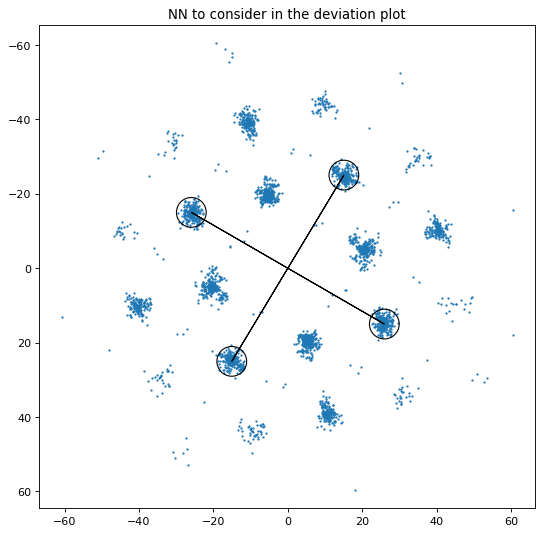

Sublattice 0:


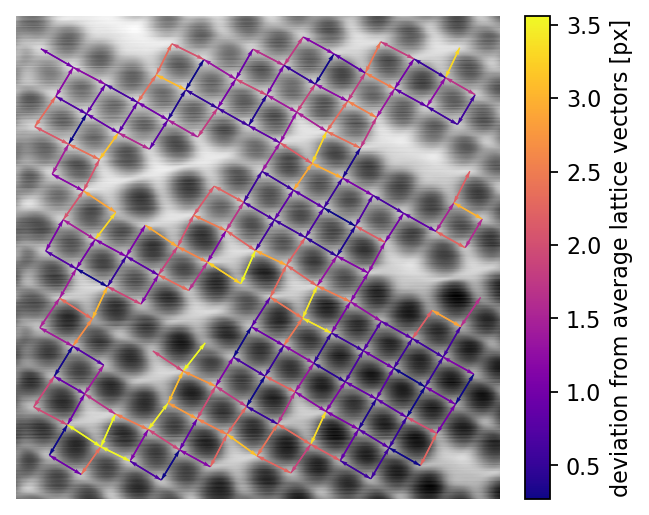

Sublattice 1:


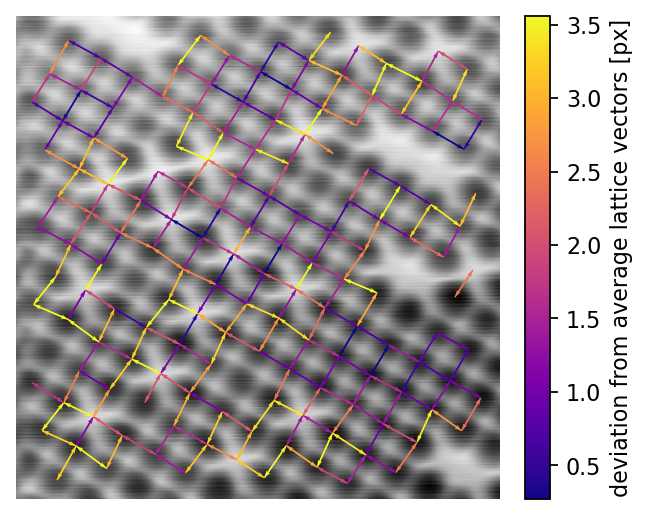

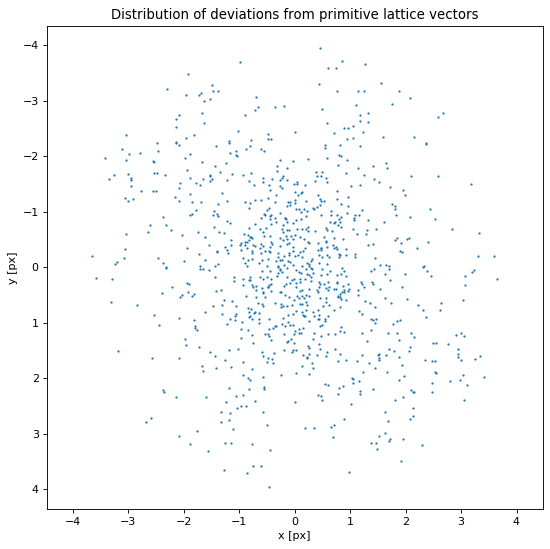

In [129]:
plot_lattice_deviations2(x, a, b, subl_labels, k2, rtol_rel, arrow_width)

Even if the calculations went well, it's possible that some atoms have not been correctly categorized. A better parameter tuning may get the situation better.

# 6. Symmetry identification

If the calculations went well up to now, we have got all the informations to compute the lattice simmetry.

[[0. 0.]]
[1.7763568394002505e-15]
[12.223900395940866]
[12.223900395940868]
[0.0]
[1.7763568394002505e-15]
[1.8284090886533033]
[1.8284090886533018]
[0.0]
[0.0]
[8.83228299838324]
[8.832282998383244]
[0.0]


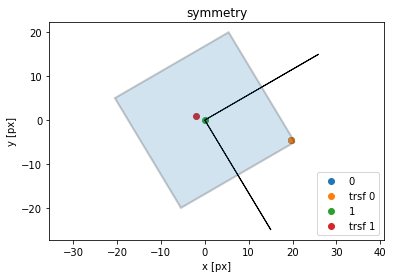

[1.7763568394002505e-15]
[2.107637664983991]


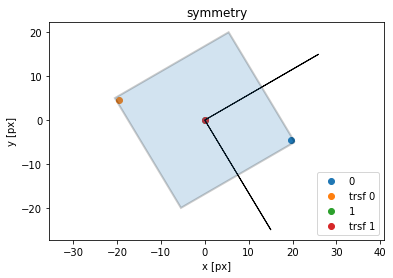

[2.107637664983994]
[0.0]
[1.7763568394002505e-15]
[1.2649069879194712]
[1.2649069879194716]
[0.0]
[1.7763568394002505e-15]
[1.8135922245314022]
[1.8135922245314013]
[0.0]
[3.552713678800501e-15]
[0.4374065097447155]
[0.4374065097447173]
[0.0]
[3.552713678800501e-15]
[2.329954480027465]
[2.3299544800274656]
[0.0]
{'rot_60': [[False], [False]], 'rot_90': [[True], [True]], 'rot_120': [[False], [False]], 'rot_180': [[True], [True]], 'mir_hor': [[True], [True]], 'mir_ver': [[True], [True]], 'mir_dia_1': [[True], [True]], 'mir_dia_2': [[True], [True]]}


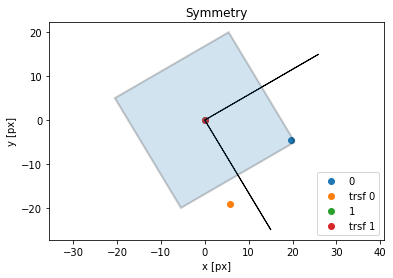

In [130]:
# Example: Square
# a = np.array([10, 0])
# b = np.array([0, 10])
# subl = np.array([np.array([0,0]), np.array([0.5,0.5])])

center_atom_cluster = 1

def Rot_matrix(angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.array(((c, -s), (s, c)))

brillouin_zone = np.array([(a+b)/2, (a-b)/2, (-a-b)/2, (-a+b)/2, (a+b)/2])
brillouin_zone_path = matplotlib.path.Path(brillouin_zone)

lattice_complete = [[None]]*len(np.unique(atomtypes))
lattice = []

for i in [-2, -1, 0, 1 ,2]:
    for k in [-2, -1, 0, 1, 2]:
        lattice.append(i*a + k*b)

for i in range(len(atomtypes)):
    if None in lattice_complete[atomtypes[i]]:
        lattice_complete[atomtypes[i]] = lattice + subl[i][0]*a + subl[i][1]*b
    else:
        lattice_complete[atomtypes[i]] = np.append(lattice_complete[atomtypes[i]], 
                                                   lattice + subl[i][0]*a + subl[i][1]*b,
                                                   axis=0)

lattice_complete = np.array(lattice_complete)

symmetry_results = []
symmetry_bool = []



for k in [atomtypes[center_atom_cluster]]:   # <- DEPRECATED
    lattice_construct = []
    lattice_complete_shift = []
    for i in range(len(lattice_complete)):
        #center at zeroth element of ith atomtype
        lattice_complete_shift.append(lattice_complete[i] - lattice_complete[k][12])
        lattice_construct.append(lattice_complete[i] - lattice_complete[k][12])
        bool = brillouin_zone_path.contains_points(lattice_construct[i], transform=None, 
                                                   radius=0)
        lattice_construct[i] = lattice_construct[i][bool]

    # Check if symmetry satisfied
    Ref_Angles = [
        np.arctan2(a[1], a[0]),                # 1st Parallel of boundary
        np.arctan2(b[1], b[0]),                # 2nd Parallel of boundary
        np.arctan2(a[1]+b[1], a[0]+b[0]),      # 1st Diagonal of boundary
        np.arctan2(a[1]-b[1], a[0]-b[0]),]     # 2nd Diagonal of boundary

    symmetry_transforms = {}

    symmetry_transforms = {
        "rot_60" : [],
        "rot_90" : [],
        "rot_120" : [],
        "rot_180" : [],
        "mir_hor" : [],
        "mir_ver" : [],
        "mir_dia_1" : [],
        "mir_dia_2" : [],
    }

    for i in range(len(lattice_complete)):
        symmetry_transforms["rot_60"].append([np.dot(ele, Rot_matrix(np.radians(60))) 
                                              for ele in lattice_construct[i]])
        symmetry_transforms["rot_90"].append([np.dot(ele, Rot_matrix(np.radians(90)))
                                              for ele in lattice_construct[i]])
        symmetry_transforms["rot_120"].append([np.dot(ele, Rot_matrix(np.radians(120)))
                                               for ele in lattice_construct[i]])
        symmetry_transforms["rot_180"].append([np.dot(ele, Rot_matrix(np.radians(180)))
                                               for ele in lattice_construct[i]])

        symmetry_transforms["mir_hor"].append([np.dot(ele, Rot_matrix(Ref_Angles[0]))
                                               for ele in lattice_construct[i]])
        symmetry_transforms["mir_hor"][i] = [[ele[0], -ele[1]]
                                             for ele in symmetry_transforms["mir_hor"][i]]
        symmetry_transforms["mir_hor"][i] = [np.dot(ele, Rot_matrix(-Ref_Angles[0]))
                                             for ele in symmetry_transforms["mir_hor"][i]]

        symmetry_transforms["mir_ver"].append([np.dot(ele, Rot_matrix(Ref_Angles[1]))
                                               for ele in lattice_construct[i]])
        symmetry_transforms["mir_ver"][i] = [[ele[0], -ele[1]]
                                             for ele in symmetry_transforms["mir_ver"][i]]
        symmetry_transforms["mir_ver"][i] = [np.dot(ele, Rot_matrix(-Ref_Angles[1]))
                                             for ele in symmetry_transforms["mir_ver"][i]]

        symmetry_transforms["mir_dia_1"].append([np.dot(ele, Rot_matrix(Ref_Angles[2]))
                                                 for ele in lattice_construct[i]])
        symmetry_transforms["mir_dia_1"][i] = [[ele[0], -ele[1]]
                                               for ele in symmetry_transforms["mir_dia_1"][i]]
        symmetry_transforms["mir_dia_1"][i] = [np.dot(ele, Rot_matrix(-Ref_Angles[2]))
                                               for ele in symmetry_transforms["mir_dia_1"][i]]

        symmetry_transforms["mir_dia_2"].append([np.dot(ele, Rot_matrix(Ref_Angles[3]))
                                                 for ele in lattice_construct[i]])
        symmetry_transforms["mir_dia_2"][i] = [[ele[0], -ele[1]] \
                                               for ele in symmetry_transforms["mir_dia_2"][i]]
        symmetry_transforms["mir_dia_2"][i] = [np.dot(ele, Rot_matrix(-Ref_Angles[3]))
                                               for ele in symmetry_transforms["mir_dia_2"][i]]
    
    symmetry_results = {
           "rot_60" :    [],
           "rot_90" :    [],
           "rot_120" :   [],
           "rot_180" :   [],
           "mir_hor" :   [],
           "mir_ver" :   [],
           "mir_dia_1" : [],
           "mir_dia_2" : [],
    }

    symmetry_bool = {
           "rot_60" :    [],
           "rot_90" :    [],
           "rot_120" :   [],
           "rot_180" :   [],
           "mir_hor" :   [],
           "mir_ver" :   [],
           "mir_dia_1" : [],
           "mir_dia_2" : [],
    }
    
    symmetry_shift_vectors = {
           "rot_60" :    [],
           "rot_90" :    [],
           "rot_120" :   [],
           "rot_180" :   [],
           "mir_hor" :   [],
           "mir_ver" :   [],
           "mir_dia_1" : [],
           "mir_dia_2" : [],
    }
    
    print(lattice_construct[1])
    for key in symmetry_transforms:
        symmetry_shifted = np.empty_like(symmetry_transforms[key])
        for l in range(len(lattice_complete)): #atomtypes
            symmetry_results[key].append([])
            symmetry_bool[key].append([])
            symmetry_shift_vectors[key].append([])
            index = 0
            for m in range(len(lattice_construct[l])): #number of atoms of atomtypes
                for j in range(len(lattice_construct[l])):
                    symmetry_results[key][l].append([])
                    symmetry_bool[key][l].append(True)
                    symmetry_shift_vectors[key].append(symmetry_transforms[key][l][j]
                                                       -lattice_construct[l][m])
                    for n in range(len(lattice_complete)): #shift all atomtypes accordingly
                        symmetry_shifted[n] = symmetry_transforms[key][n]\
                                            - (symmetry_transforms[key][l][j]\
                                            - lattice_construct[l][m])
                        
                        for k in range(len(symmetry_shifted[n])): # Apply PBC
                            basis_matrix = np.array([[a[0], b[0]], [a[1], b[1]]])
                            lst_trf = np.linalg.solve(basis_matrix, symmetry_shifted[n][k])
                            lst_trf[0] -= round(lst_trf[0])
                            lst_trf[1] -= round(lst_trf[1])
                            # if lst_trf[0] > 1:
                            #     lst_trf[0] = lst_trf[0] % 1
                            # if lst_trf[0] < 0:
                            #     lst_trf[0] = lst_trf[0] % 1
                            # if lst_trf[1] > 1:
                            #     lst_trf[1] = lst_trf[1] % 1
                            # if lst_trf[1] < 0:
                            #     lst_trf[1] = lst_trf[1] % 1
                            # lst_trf = lst_trf - np.array([0.5, 0.5])
                            lst_trf = np.dot(basis_matrix, lst_trf)
                            symmetry_shifted[n][k] = lst_trf
                        
                    if key == "rot_180":
                        fig, ax = plt.subplots()
                        plt.title("symmetry")
                        plt.xlabel("x [px]")
                        plt.ylabel("y [px]")
                        plt.axis("equal")
                        #plt.xlim((-15, 15))
                        #plt.ylim((-15, 15))
                            #plt.scatter([lst[0] for lst in lattice_complete_shift[i]],
                            #[lst[1] for lst in lattice_complete_shift[i]],
                            #label = str(i))
                            #plt.scatter([lst[0] for lst in symmetry_shifted[i]],
                            #[lst[1] for lst in symmetry_shifted[i]],
                            #label = "trsf " + str(i))
                        for i in range(len(lattice_complete)):
                            plt.scatter([lst[0] for lst in lattice_construct[i]],
                                        [lst[1] for lst in lattice_construct[i]],
                                        label = str(i))
                            plt.scatter([lst[0] for lst in symmetry_shifted[i]],
                                        [lst[1] for lst in symmetry_shifted[i]],
                                        label = "trsf " + str(i))
                        ax.legend()
                        plt.arrow(0, 0, a[0], a[1])
                        plt.arrow(0, 0, b[0], b[1])

                        patch = patches.PathPatch(matplotlib.path.Path(brillouin_zone), 
                                                  alpha = 0.2, lw=2)
                        ax.add_patch(patch)
                        plt.show()
                    
                    bool = []                    
                    for n in range(len(lattice_complete)):
                        bool.append([])                    
                        for k in range(len(symmetry_shifted[n])):
                            bool[n].append([])                    
                            distances = []
                            for o in range(len(lattice_construct[n])):
                                lst_trf = symmetry_shifted[n][k] - lattice_construct[n][o]
                                basis_matrix = np.array([[a[0], b[0]], [a[1], b[1]]])
                                lst_trf = np.linalg.solve(basis_matrix, lst_trf)
                                lst_trf[0] -= round(lst_trf[0])
                                lst_trf[1] -= round(lst_trf[1])
                                #if lst_trf[0] > 0:
                                #    lst_trf[0] = lst_trf[0] % 0.5
                                #elif lst_trf[0] < 0:
                                #    lst_trf[0] = lst_trf[0] % 0.5
                                #if lst_trf[1] > 0:
                                #    lst_trf[1] = lst_trf[1] % 0.5
                                #elif lst_trf[1] < 0:
                                #    lst_trf[1] = lst_trf[1] %
                                lst_trf = np.dot(basis_matrix, lst_trf)
                                distances.append(np.linalg.norm(lst_trf))
                            if min(distances) < 6:
                                bool[n][k] = [min(distances)]
                            print(distances)
                        symmetry_results[key][l][index].append(bool[n])
                    
                    index = index + 1

        for l in range(len(lattice_complete)):
            for m in range(len(symmetry_results[key][l])):
                for atoms in symmetry_results[key][l][m]:
                    for neighbours in atoms:
                        if not neighbours:
                            symmetry_bool[key][l][m] = False
        
    print(symmetry_bool)

    fig, ax = plt.subplots()
    plt.title("Symmetry")
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.axis("equal")
    #plt.xlim((-15, 15))
    #plt.ylim((-15, 15))

    for i in range(len(lattice_complete)):
        plt.scatter([lst[0] for lst in lattice_construct[i]], 
                    [lst[1] for lst in lattice_construct[i]],
                    label = str(i))
        plt.scatter([lst[0] for lst in symmetry_transforms["rot_60"][i]],
                    [lst[1] for lst in symmetry_transforms["rot_60"][i]],
                    label = "trsf " + str(i))
    ax.legend()
    plt.arrow(0,0,a[0],a[1])
    plt.arrow(0,0,b[0],b[1])

    patch = patches.PathPatch(matplotlib.path.Path(brillouin_zone), alpha = 0.2, lw=2)
    ax.add_patch(patch)
    plt.show()


In [131]:
Plane_Group_Bool = []

Plane_Group_Symm = {
#            60  90 120 180 Hor Ver Di1 Di2
    'p1':  [  0,  0,  0,  0,  0,  0,  0,  0],
    'p2':  [  0,  0,  0,  1,  0,  0,  0,  0],
    'pm_a':[  0,  0,  0,  0,  1,  0,  0,  0],
    'pm_b':[  0,  0,  0,  0,  0,  1,  0,  0],
    #'#pg
    'cm_a':[  0,  0,  0,  0,  0,  0,  1,  0],
    'cm_b':[  0,  0,  0,  0,  0,  0,  0,  1],
    'pmm': [  0,  0,  0,  1,  1,  1,  0,  0],
    'pmg_a':[ 0,  0,  0,  1,  1,  0,  0,  0],
    '''pmg is unique in having 180° and Primary axis reflection, It also has glide ref'''
    'pmg_b':[ 0,  0,  0,  1,  0,  1,  0,  0],
    '''On other primary axis. Technically we dont need to check glide refl. since unique.'''
    #'#pgg
    'cmm': [  0,  0,  0,  1,  0,  0,  1,  1],
    'p4 ': [  0,  1,  0,  1,  0,  0,  0,  0],
    'p4m': [  0,  1,  0,  1,  1,  1,  1,  1],
    'p4g': [  0,  1,  0,  1,  0,  0,  1,  1],
    '''p4g is unique in having 4fold and diagonal reflections.
    Technically we dont need to check glide ref.
    But maybe we do??? Wikipedia says otherwise??'''
    'p3':  [  0,  0,  1,  0,  0,  0,  0,  0],
    'p3m1_a':[0,  0,  1,  0,  0,  0,  1,  0],
    'p3m1_b':[0,  0,  1,  0,  0,  0,  0,  1],
    'p31m_a':[0,  0,  1,  0,  1,  1,  1,  0],
    'p31m_b':[0,  0,  1,  0,  1,  1,  0,  1],
    'p6':  [  1,  0,  1,  1,  0,  0,  0,  0],
    'p6m': [  1,  0,  1,  1,  1,  1,  1,  1]}


global_symmetry = {
           "rot_60" :    0,
           "rot_90" :    0,
           "rot_120" :   0,
           "rot_180" :   0,
           "mir_hor" :   0,
           "mir_ver" :   0,
           "mir_dia_1" : 0,
           "mir_dia_2" : 0,}


for l in range(len(lattice_complete)):
    Plane_Group_Bool.append([])
    for m in range(len(symmetry_bool["rot_60"][l])):
        Plane_Group_Bool[l].append({
                "p1": False,
                "p2": False,
                "pm_a": False,
                "pm_b": False,
                "pg": False,
                "cm_a": False,
                "cm_b": False,
                "pmm": False,
                "pmg_a": False,
                "pmg_b": False,
                "pgg": False,
                "cmm": False,
                "p4": False,
                "p4m": False,
                "p4g": False,
                "p3": False,
                "p3m1_a": False,
                "p3m1_b": False,
                "p31m_a": False,
                "p31m_b": False,
                "p6": False,
                "p6m": False})
        flat_symmetry = []
        for keys in symmetry_bool:
            flat_symmetry.append(symmetry_bool[keys][l][m])
            if global_symmetry[keys] == 0 and symmetry_bool[keys][l][m] == 1:
                 global_symmetry[keys] += 1
        for key in Plane_Group_Symm:
            if (Plane_Group_Symm[key] == flat_symmetry):
                Plane_Group_Bool[l][m][key] = True

                print('Center on Atomtype', l, ' with Basis traf Index ', m, '-> ',
                      key, 'detected')

flat_symmetry = []
for key in global_symmetry:
    flat_symmetry.append(global_symmetry[key])

for key in Plane_Group_Symm:   
    if (flat_symmetry == Plane_Group_Symm[key]):
            print(key, " detectecd")

Center on Atomtype 0  with Basis traf Index  0 ->  p4m detected
Center on Atomtype 1  with Basis traf Index  0 ->  p4m detected
p4m  detectecd


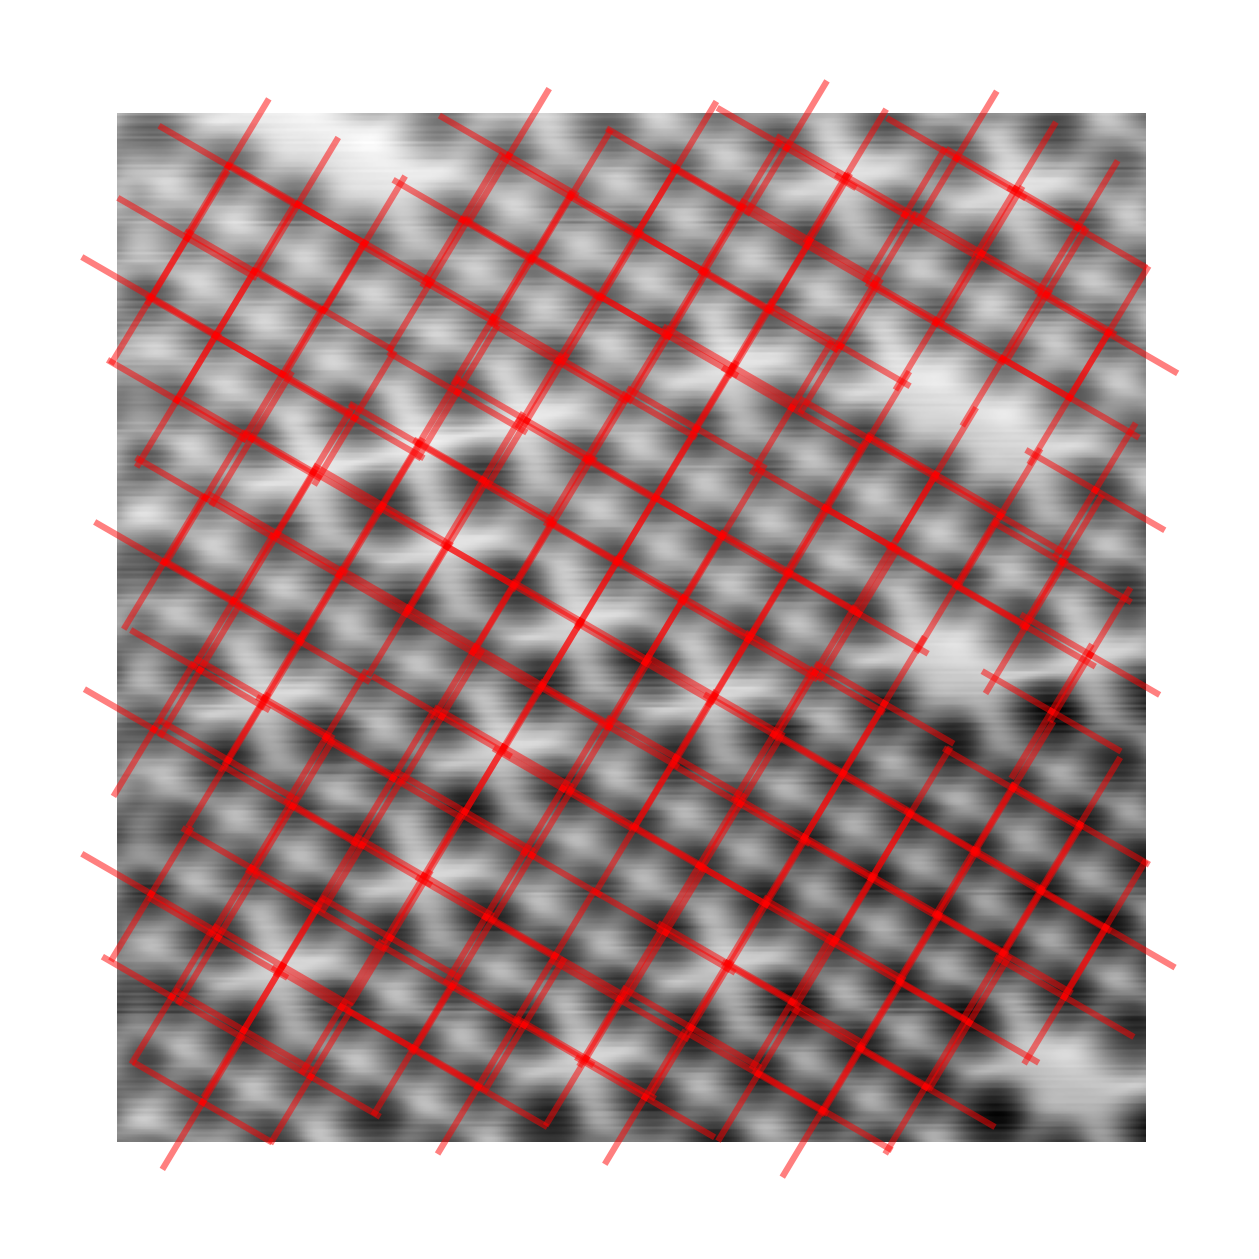

400 400


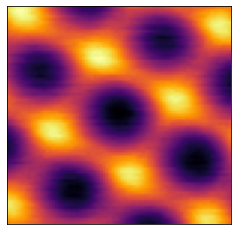

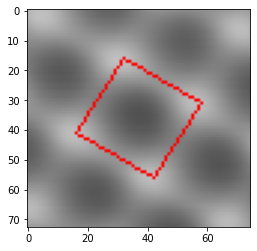

In [132]:
from PIL import Image, ImageDraw

#Mean cell averaging
'''
With lengthener 1 only the unit cells are averaged and displayed.
With lengthener = 2 the average is done with twice as long unit vectors
and the surrounding area is included in the average.
'''
lengthener = 1.8 

orig_img = img

# matplot_img = plt.imread("experiments/Graphene 8x8nm, stiff tip, close.png")

# height, width = img.shape[:2]
fig = plt.figure(dpi=300)

ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(img)
plt.axis("off")
plt.box(False)
# mpl.rcParams["savefig.pad_inches"] = 0

coordinates = x[subl_labels == center_atom_cluster]

cropping_points = np.zeros( # Determine Wigner-Seit-Cell for sublattice determination
    (len(coordinates), 4, 2)).tolist()

display_points = np.zeros(
    (len(coordinates), 4, 2)).tolist()  # Only for plotting

for i in range(len(coordinates)):
    kp_x = int(round(coordinates[i][0]))
    kp_y = int(round(coordinates[i][1]))

    display_points[i][0][0] = int(
        kp_x + round((a[0] + b[0]) * 0.5 * lengthener)
    )
    display_points[i][0][1] = int(
        kp_y + round((a[1] + b[1]) * 0.5 * lengthener)
    )
    display_points[i][2][0] = int(
        kp_x + round((-1 * a[0] - b[0]) * 0.5 * lengthener)
    )
    display_points[i][2][1] = int(
        kp_y + round((-1 * a[1] - b[1]) * 0.5 * lengthener)
    )
    display_points[i][1][0] = int(
        kp_x + round((-1 * a[0] + b[0]) * 0.5 * lengthener)
    )
    display_points[i][1][1] = int(
        kp_y + round((-1 * a[1] + b[1]) * 0.5 * lengthener)
    )
    display_points[i][3][0] = int(
        kp_x + round((a[0] - b[0]) * 0.5 * lengthener)
    )
    display_points[i][3][1] = int(
        kp_y + round((a[1] - b[1]) * 0.5 * lengthener)
    )

    ax.plot(
        [kp_x, (kp_x + a[0])],
        [kp_y, (kp_y + a[1])],
        "r-",
        alpha=0.5,
    )
    ax.plot(
        [kp_x, (kp_x + b[0])],
        [kp_y, (kp_y + b[1])],
        "r-",
        alpha=0.5,
    )
    ax.plot(
        [kp_x, (kp_x - a[0])],
        [kp_y, (kp_y - a[1])],
        "r-",
        alpha=0.5,
    )
    ax.plot(
        [kp_x, (kp_x - b[0])],
        [kp_y, (kp_y - b[1])],
        "r-",
        alpha=0.5,
    )
    
    #ax.plot(kp_x, kp_y, "ro-", alpha=0.3)

plt.show()

##### Sum unit cells
#  Gives averaged view of lattice
imgList = []
first = True
cropped_list = []

height, width, channels = orig_img.shape
print(height, width)
for i in range(len(coordinates)):
    mask = np.zeros(orig_img.shape[0:2], dtype=np.uint8)
    points = np.array(display_points[i])
    good_cell = True
    for k in range(len(points)):
        if (
            points[k][0] < 0
            or points[k][0] > width - 1
            or points[k][1] < 0
            or points[k][1] > height - 1
        ):
            good_cell = False
            #print("unit display outside image, not taken into account")
    if good_cell:
        cv.drawContours(mask, [points], -1, (255, 255, 255), -1, cv.LINE_AA)

        # method 2 not so smooth region
        # cv2.fillPoly(mask, points, (255))

        res = orig_img

        rect = cv.boundingRect(points)  # returns (x,y,w,h) of the rect
        cropped = res[rect[1] : rect[1] + rect[3], rect[0] : rect[0] + rect[2]]
        cropped = cv.cvtColor(cropped, cv.COLOR_BGR2GRAY)
        cropped_list.append(cropped)
        # cv.imwrite("Cropped.png", cropped)
        ## crate the white background of the same size of original image
        wbg = np.ones_like(orig_img, np.uint8) * 255
        cv.bitwise_not(wbg, wbg, mask=mask)
        # overlap the resulted cropped image on the white background
        dst = wbg + res
        # write_cropped = cv.cvtColor(cropped, cv.COLOR_BGR2RGB)
        # cv.imwrite("for_super_resolution/Cropped_" + str(i) + ".png", cropped)

        pil_im = Image.fromarray(cropped)
        imgList.append(pil_im)

        temp = np.asarray(cropped)
        temp = temp.astype("uint32")
        if first:
            sumImage = temp
            first = False
        else:
            sumImage = sumImage + temp


avgArray = sumImage / len(imgList)
avgImg = Image.fromarray(avgArray.astype("uint8"))
# avgImg.save("av_cropped.png")

cropped_list = np.array(cropped_list)
median_cropped = np.empty_like(cropped)

for i in range(len(cropped)):
    for k in range(len(cropped[0])):
        median_cropped[i][k] = np.median(cropped_list[:, i, k])

median_cropped = median_cropped.astype(np.int32)
median_img = Image.fromarray(median_cropped.astype("uint8"))

fig = plt.figure()
plt.imshow(median_cropped, cmap="inferno")
plt.tick_params(axis='both', which='both', bottom=False,
                top=False, labelbottom=False, right=False,
                left= False, labelleft=False)
plt.show()

width, height = avgImg.size
center = np.array([width/2, height/2])

wigner_seitz_cell = np.array(
    [
        center + (a+b) / 2,
        center + (-1*a+b) / 2,
        center + (-1*a-b) / 2,
        center + (a-b) / 2,
    ]
)
wigner_seitz_cell = tuple(map(tuple, wigner_seitz_cell))
avgImg_RGB = avgImg.convert("RGB")
img_draw = ImageDraw.Draw(avgImg_RGB)
img_draw.polygon(wigner_seitz_cell, outline="red")

fig = plt.figure()
plt.imshow(avgImg_RGB, cmap="inferno")
#plt.tick_params(axis='both', which='both', bottom= False, top= False, labelbottom= False, right= False, left= False, labelleft= False)
plt.show()

# avgImg.save("av_cropped_cell.png")

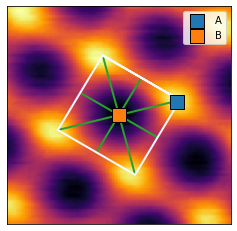

In [133]:
fig, ax = plt.subplots()

# plt.title("symmetry")
#plt.xlabel("x [px]")
#plt.ylabel("y [px]")
#plt.axis("equal")

#plt.xlim((min(-a[0], -b[0]), max(a[0], b[0])))
#plt.ylim((min(-a[0], -b[0]), max(a[0], b[0])))

# To plot we need to invert y-axis!?
a[1] = -a[1]
b[1] = -b[1]
l = 1
m = 0


if symmetry_bool["mir_hor"][l][m]:
    #plt.plot([-a[0]/2, a[0]/2], [-a[1]/2, a[1]/2], color = 'black', lw = 3, zorder = 1)
    plt.plot([-a[0]/2.05, a[0]/2.05], [-a[1]/2.05, a[1]/2.05], color = 'tab:green', lw = 2, zorder = 1,)

if symmetry_bool["mir_ver"][l][m]:
    #plt.plot([-b[0]/2, b[0]/2], [-b[1]/2, b[1]/2], color = 'black', lw = 3, zorder = 1)
    plt.plot([-b[0]/2.05, b[0]/2.05], [-b[1]/2.05, b[1]/2.05], color = 'tab:green', lw = 2, zorder = 1)

if symmetry_bool["mir_dia_1"][l][m]:
    #plt.plot([-(a[0] + b[0])/2, (a[0] + b[0])/2], [-(a[1] + b[1])/2, (a[1] + b[1])/2], color = 'black', lw = 3, zorder = 1)
    plt.plot([-(a[0] + b[0])/2.05, (a[0] + b[0])/2.05], [-(a[1] + b[1])/2.05, (a[1] + b[1])/2.05], color = 'tab:green', lw = 2, zorder = 1)

if symmetry_bool["mir_dia_2"][l][m]:
    #plt.plot([-(a[0] - b[0])/2, (a[0] - b[0])/2], [-(a[1] - b[1])/2, (a[1] - b[1])/2], color = 'black', lw = 3, zorder = 1)
    plt.plot([-(a[0] - b[0])/2.05, (a[0] - b[0])/2.05], [-(a[1] - b[1])/2.05, (a[1] - b[1])/2.05], color = 'tab:green', lw = 2, zorder = 1)

label = [["A", None, None, None], ["B", None, None, None], ["C", None, None, None]]
colors = ["tab:blue", "tab:orange"]

for i in range(len(lattice_complete)):
    self_trf_Index = 0
    for k in range(len(lattice_construct[i])):
        if symmetry_bool["rot_60"][i][self_trf_Index]:
            plt.scatter(lattice_construct[i][k][0], -lattice_construct[i][k][1], label = label[i][k], marker = "h", s = 170, color = "tab:blue", edgecolors='black', zorder = 20)
        elif symmetry_bool["rot_90"][i][self_trf_Index]:
            plt.scatter(lattice_construct[i][k][0], -lattice_construct[i][k][1], label = label[i][k], marker = "s", s = 170, color = colors[i], edgecolors='black', zorder = 20)
        elif symmetry_bool["rot_120"][i][self_trf_Index]:
            plt.scatter(lattice_construct[i][k][0], -lattice_construct[i][k][1], label = label[i][k], marker = "^", s = 170, color = "tab:red", edgecolors='black', zorder = 20)
        elif symmetry_bool["rot_180"][i][self_trf_Index]:
            plt.scatter(lattice_construct[i][k][0], -lattice_construct[i][k][1], label = label[i][k], marker = "d", s = 170, color = "tab:pink", edgecolors='black', zorder = 20)
        else:
            plt.scatter(lattice_construct[i][k][0], -lattice_construct[i][k][1], label = label[i][k], s = 170, color = colors[i], edgecolors='black', zorder = 20)
        self_trf_Index += len(lattice_construct[i]) + 1   

ax.legend()
#plt.arrow(0,0,a[0],a[1])
#plt.arrow(0,0,b[0],b[1])
brillouin_zone_plot = np.array([(a+b)/2, (a-b)/2, -(a+b)/2, (-1*a+b)/2, (a+b)/2, (a-b)/2]) #to get pretty edges added one additional
patch = patches.PathPatch(matplotlib.path.Path(brillouin_zone_plot), alpha = 1, lw=2, zorder = 5, facecolor='none', edgecolor = "ghostwhite")
ax.add_patch(patch)

plt.imshow(avgImg, cmap="inferno", extent=[-width/2., width/2., -height/2., height/2. ])
plt.tick_params(axis='both', which='both', bottom= False, top= False, labelbottom= False, right= False, left= False, labelleft= False)

plt.savefig(path+"symmetry_cell_avg.svg", bbox_inches='tight', dpi = 200)

plt.imshow(median_img, cmap="inferno", extent=[-width/2., width/2., -height/2., height/2. ])
plt.tick_params(axis='both', which='both', bottom= False, top= False, labelbottom= False, right= False, left= False, labelleft= False)

plt.savefig(path+"symmetry_cell_median.svg", bbox_inches='tight', dpi = 200)


a[1] = -a[1]
b[1] = -b[1]